In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# A 2D vector utility
class Vec():
    def __init__(self, v):
        v = np.array(v)
        self.v = v.astype(float)
    def dist_from(self, w):
        return np.sqrt(np.sum(np.power(self.v-w.v,2)))
    def length(self):
        return np.sqrt(np.sum(np.power(self.v,2)))
    def add(self, w):
        return Vec(self.v + w.v)
    def sub(self, w):
        return Vec(self.v - w.v)
        return cp
    def rotate(self, a):
        x = self.v[0]*math.cos(a) + self.v[1]*math.sin(a)
        y = -self.v[0]*math.sin(a) + self.v[1]*math.cos(a)
        return Vec(np.array([x,y]))
    def copy(self):
        return Vec(np.array([self.v[0],self.v[1]]))
    def scale(self, s):
        self.v = self.v * s
    def normalize(self):
        d = self.length()
        self.scale(1.0/d)

In [3]:
class SinForce():
    def __init__(self, initial_force, wavelength):
        self.initial_force = initial_force
        self.temp = 0
        self.wavelength = wavelength
    def get_force(self, time):
        self.temp = self.initial_force.copy()
        self.temp.scale(math.sin(2*math.pi*time/self.wavelength))
        return self.temp;
    def new_magnitude(self, mag):
        if np.abs(mag) > 0:
            self.initial_force.normalize();
            self.initial_force.scale(mag)
    def new_wavelength(self, w):
        if w > 0:
            self.wavelength = w;
    def draw(self, time):
#         print "drew force"
        return

In [4]:
# An abstract fractal object
class Fractal():
    def __init__(self, world, depth):
        #properties
        self.isHead = True
        self.depth = depth
        self.rule = TreeRule(scale=0.6)
        self.rad = 30

        #translation dynamics
        self.m = math.pi*self.rad*self.rad
        self.tk = 500
        self.rk = 1
        self.tDamping = 0.025
        self.forceScale = 0.1

        self.p = Vec([world.v[0]/2, world.v[1] - self.rad])
        self.v = Vec([0,0])
        self.a = Vec([0,0])
        self.eqLength = 170

        #rotation dynamics
        self.theta = 0
        self.w = 0
        self.rDamping = 0
        self.eqChildThetas = []

        #world
        self.world = world
        self.data = {}
        self.data["x"] = np.zeros((0,2)); self.data["v"] = np.zeros((0,2))

        #nodes
        self.children = self.rule.getChildren(self)
        self.index = 0

        for child in self.children:
            connection = child.p.sub(self.p)
            self.eqChildThetas.append( math.atan2(connection.v[0], connection.v[1]) - self.theta )
    def draw(self):
#         print "draw top node"
        for child in self.children:
            child.draw();
    def tick(self, force):
#         print "tick top node"
        force.scale(self.forceScale)
        if len(self.children) > 0:
            for child in self.children:
                self.data = child.tick(force, self.data)

In [5]:
# defines node-level behavior of fractal
class Node():
    def __init__(self, parent, index, p, reportData):
        #properties
        self.isHead = False;
        self.depth = parent.depth - 1;
        self.rule = parent.rule;
        self.rad = parent.rad * parent.rule.scale;

        #translational dynamics
        self.m = math.pi*self.rad*self.rad;
        self.tk = parent.tk * parent.rule.scale * parent.rule.scale;
        self.rk = parent.rk * parent.rule.scale;
        self.tDamping = parent.tDamping;

        self.p = p;
        self.v = parent.v.copy();
        self.a = parent.a.copy();
        self.eqLength = parent.eqLength*parent.rule.scale;

        #rotational dynamics
        self.theta = parent.theta;
        self.w = parent.w;
        self.rDamping = parent.rDamping;

        #world
        self.world = parent.world;
        self.reportData = reportData

        #nodes
        self.parent = parent;
        self.index = index
        self.children = self.rule.getChildren(self);

        connection = self.p.sub(self.parent.p);
        self.eqParentTheta = math.atan2(connection.v[0], connection.v[1]) - self.theta;
        self.eqChildThetas = [];
        for child in self.children:
            connection = child.p.sub(self.p)
            self.eqChildThetas.append( math.atan2(connection.v[0], connection.v[1]) - self.theta )
    def draw(self):
#         print "draw node "
        for child in self.children:
            child.draw();
    def tick(self, force, data):
        #calculate acceleration
        self.a.scale(0);
        alpha = 0;
        if len(self.children) > 0:
            for c, child in enumerate(self.children):
                #rotational part
                connection = child.p.sub(self.p)
                connectionTheta = math.atan2(connection.v[0], connection.v[1]) - self.theta
                dtheta = connectionTheta - self.eqChildThetas[c]
                if dtheta > math.pi:
                    dtheta = -1*math.pi + (dtheta - math.pi)
                dtheta = math.sin(dtheta)

                if np.abs(dtheta) > 0.00001:
                    child_alpha = self.eqLength*(self.rk*dtheta)*2/(self.m*self.rad*self.rad)

                    #translational ---> rotational
                    a_from_rotation = connection.rotate(-math.pi/2)
                    a_from_rotation.normalize()
                    a_from_rotation.scale( child.m*math.pow(child.rad,3)*child_alpha/(2*self.m*self.rad) )
                    self.a = self.a.add(a_from_rotation);

                #translational part
                x = self.p.sub(child.p).length() - self.eqLength;
                if np.abs(x) > 0.00001:
                    child_a = self.p.sub(child.p);
                    child_a.normalize();
                    child_a.scale(-1*self.tk*x/self.m);
                    self.a = self.a.add(child_a);

        #acceleration from parent
        #rotational part
        connection = self.parent.p.sub(self.p);
        connectionTheta = math.atan2(connection.v[0], connection.v[1]) - self.theta;
        dtheta = connectionTheta - self.eqParentTheta;
        if dtheta > math.pi:
            dtheta = -1*math.pi + (dtheta - math.pi);
        dtheta = math.sin(dtheta);

        if np.abs(dtheta) > 0.00001:
            parent_alpha = self.parent.eqLength*(self.rk*dtheta)*2/(self.m*self.rad*self.rad);

            #translational ---> rotational
            a_from_rotation = connection.rotate(-math.pi/2);
            a_from_rotation.normalize();
            a_from_rotation.scale( self.parent.m*math.pow(self.parent.rad,3)*parent_alpha/(2*self.m*self.rad) );
            self.a = self.a.add(a_from_rotation);

        #translational part
        x = self.p.sub(self.parent.p).length() - self.parent.eqLength;
        if np.abs(x) > 0.00001:
            parent_a = self.p.sub(self.parent.p);
            parent_a.normalize();
            parent_a.scale(-1*self.tk*x/self.m);
            self.a = self.a.add(parent_a);

        #add wind to acceleration
        wind_a = force.copy();
        wind_a.scale(2*self.rad/self.m); # force goes with diameter for objects in 2D system
        self.a = self.a.add(force);

        #update position, velocity
        self.v = self.v.add(self.a);
        self.v.v -= self.v.v - self.v.v*self.tDamping;
        self.p = self.p.add(self.v);
        
        if len(self.children) > 0:
            for child in self.children:
                newdata = child.tick(force, data)
        if self.reportData:
            data["x"] = np.concatenate((data["x"], np.reshape(self.p.v,(1,2))),axis=0)
            data["v"] = np.concatenate((data["v"], np.reshape(self.v.v,(1,2))),axis=0)
        return data

In [6]:
class TreeRule():
    def __init__(self, scale=0.6):
        #properties
        self.scale = scale;
        self.branchAngles = [math.pi/6, -math.pi/6]; #angles of each of the branches
    def getChildren(self, parentNode):
        children = []
        if parentNode.depth > 0:
            if parentNode.isHead:
                p = parentNode.p.add(Vec([0,-1*parentNode.eqLength]))
                index = 0
                reportData = False
                children.append(Node(parentNode, index, p, reportData))
            else:
                for i, ba in enumerate(self.branchAngles):
                    vector = parentNode.p.sub(parentNode.parent.p)
                    vector.scale(self.scale)
                    vector = vector.rotate(ba)
                    p = parentNode.p.add(vector)
                    
                    index = i + parentNode.index
                    reportData = False
                    if False:
                        reportData = True
                    children.append(Node(parentNode, index, p, reportData))
        return children

In [7]:
initial_wav = 800
initial_mag = .99
cwidth = 700
cheight = 500

frac = Fractal(Vec([cwidth, cheight]), 6)
force = SinForce(Vec([initial_mag,0]), initial_wav)

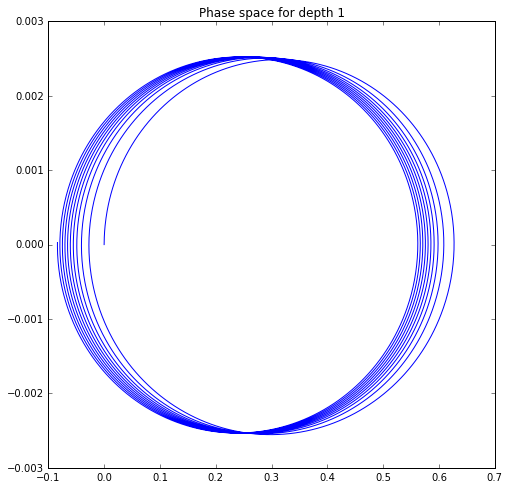

In [8]:
frac.data["x"] = np.zeros((0,2)); frac.data["v"] = np.zeros((0,2))
frac.children[0].reportData = True
count = 0
for i in range(8000):
    frac.tick(force.get_force(count))
    count +=1
    
x = frac.data["x"] - frac.data["x"][0,:]
v = frac.data["v"]

plt.figure(figsize=(8,8))
plt.figure(1)
plt.plot(x[:,0], v[:,0],'b-')
plt.title('Phase space for depth 1')
plt.show()

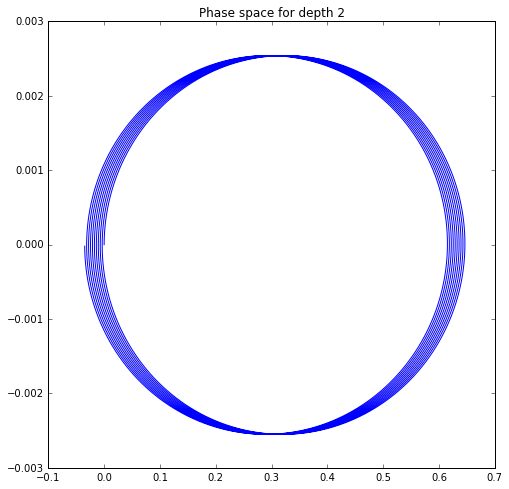

In [9]:
frac.data["x"] = np.zeros((0,2)); frac.data["v"] = np.zeros((0,2))
frac.children[0].reportData = False
frac.children[0].children[0].reportData = True
count = 0
for i in range(8000):
    frac.tick(force.get_force(count))
    count +=1
    
x = frac.data["x"] - frac.data["x"][0,:]
v = frac.data["v"]

plt.figure(figsize=(8,8))
plt.figure(1)
plt.plot(x[:,0], v[:,0],'b-')
plt.title('Phase space for depth 2')
plt.show()

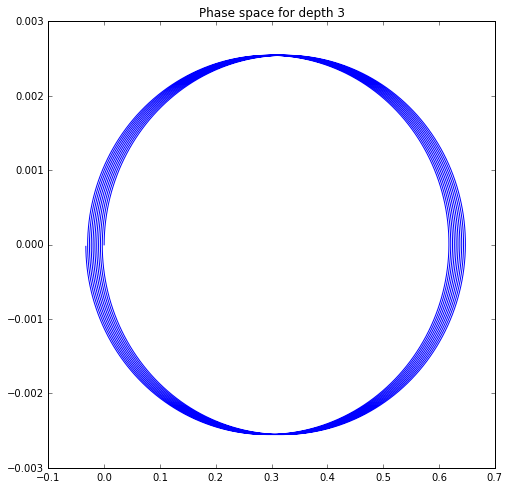

In [10]:
frac.data["x"] = np.zeros((0,2)); frac.data["v"] = np.zeros((0,2))
frac.children[0].children[0].reportData = False
frac.children[0].children[0].children[0].reportData = True
count = 0
for i in range(8000):
    frac.tick(force.get_force(count))
    count +=1
    
x = frac.data["x"] - frac.data["x"][0,:]
v = frac.data["v"]

plt.figure(figsize=(8,8))
plt.figure(1)
plt.plot(x[:,0], v[:,0],'b-')
plt.title('Phase space for depth 3')
plt.show()

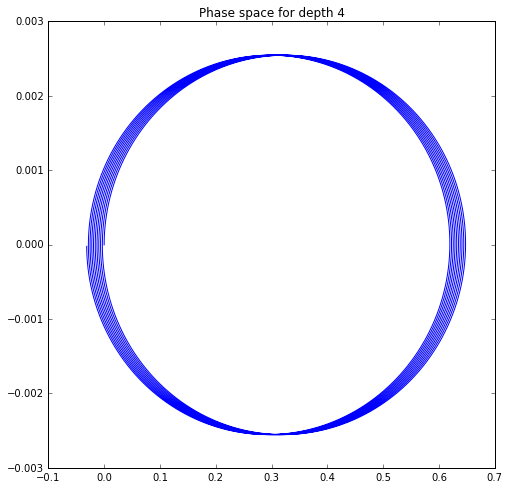

In [11]:
frac.data["x"] = np.zeros((0,2)); frac.data["v"] = np.zeros((0,2))
frac.children[0].children[0].children[0].reportData = False
frac.children[0].children[0].children[0].children[0].reportData = True
count = 0
for i in range(8000):
    frac.tick(force.get_force(count))
    count +=1
    
x = frac.data["x"] - frac.data["x"][0,:]
v = frac.data["v"]

plt.figure(figsize=(8,8))
plt.figure(1)
plt.plot(x[:,0], v[:,0],'b-')
plt.title('Phase space for depth 4')
plt.show()

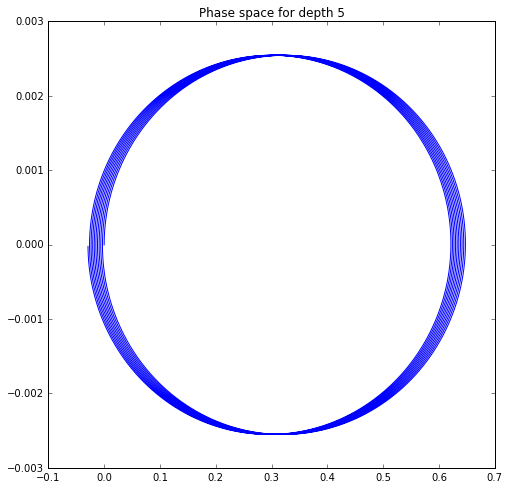

In [12]:
frac.data["x"] = np.zeros((0,2)); frac.data["v"] = np.zeros((0,2))
frac.children[0].children[0].children[0].children[0].reportData = False
frac.children[0].children[0].children[0].children[0].children[0].reportData = True
count = 0
for i in range(8000):
    frac.tick(force.get_force(count))
    count +=1
    
x = frac.data["x"] - frac.data["x"][0,:]
v = frac.data["v"]

plt.figure(figsize=(8,8))
plt.figure(1)
plt.plot(x[:,0], v[:,0],'b-')
plt.title('Phase space for depth 5')
plt.show()

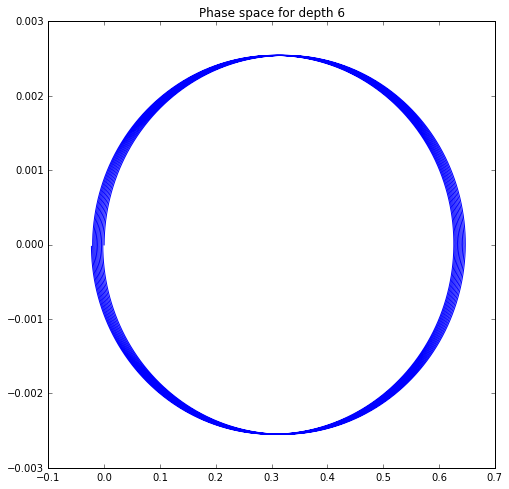

In [14]:
frac.data["x"] = np.zeros((0,2)); frac.data["v"] = np.zeros((0,2))
frac.children[0].children[0].children[0].children[0].children[0].reportData = False
frac.children[0].children[0].children[0].children[0].children[0].children[0].reportData = True
count = 0
for i in range(8000):
    frac.tick(force.get_force(count))
    count +=1
    
x = frac.data["x"] - frac.data["x"][0,:]
v = frac.data["v"]

plt.figure(figsize=(8,8))
plt.figure(1)
plt.plot(x[:,0], v[:,0],'b-')
plt.title('Phase space for depth 6')
plt.show()